In [1]:
import pandas
from consts import *
from scripts.play_with_all_data import experiment_features, cell_line_features

all_data = pandas.read_csv(DATA_PATH / 'data_from_article_fixed.csv')

In [19]:
from data_genertion.consts import *

In [3]:
# Feature generation

In [4]:
from scipy.stats import pearsonr, spearmanr

def print_correlations(df, name1, name2, p_value_threshold=None):
    if p_value_threshold is None:
        p_value_threshold = 1
    corr, p_value = pearsonr(df[name1], df[name2])
    if p_value < p_value_threshold:
        print(f"Feature: {name1:<35}, Pearson: {corr:<5.2f}, p-value: {p_value:<10.2} Target: {name2:<35}")
    corr, p_value = spearmanr(df[name1], df[name2])
    if p_value < p_value_threshold:
        print(f"Feature: {name1:<35}, Spearman: {corr:<5.2f}, p-value: {p_value:<10.2} Target: {name2:<35}")

In [5]:
import numpy as np

all_data_no_nan = all_data.dropna(subset=[INHIBITION]).copy()
all_data_no_nan.loc[:, 'log_inhibition'] = -np.log(-all_data_no_nan[INHIBITION] + 100.001)

In [6]:
from read_human_genome import get_locus_to_data_dict
gene_to_data = get_locus_to_data_dict(include_introns=True)

Time took to read fasta: 8.895147562026978


In [7]:
from consts import HUMAN_DB_BASIC_INTRONS
import gffutils

db = gffutils.FeatureDB(str(HUMAN_DB_BASIC_INTRONS))
gene = db.features_of_type('gene')

In [8]:
all_data_no_nan_human = all_data_no_nan[all_data_no_nan[CELL_LINE_ORGANISM] == 'human']
genes = all_data_no_nan[CANONICAL_GENE].copy()
genes_u = list(set(genes))
genes_u.remove('HBV')
genes_u.remove('negative_control')

In [9]:
list(gene_to_data.items())[0][1].full_mrna

Seq('AGGGGCGCGCAGCGCCGGCGCAGGCGCAGGCGCGGAGGGGCGCGCCCGAACCCG...TGC')

In [10]:
from asodesigner.util import get_antisense

all_data_human_gene = all_data_no_nan_human[all_data_no_nan_human[CANONICAL_GENE].isin(genes_u)].copy()
PREMRNA_FOUND = 'pre_mrna_found'
SENSE_START = 'sense_start'
SENSE_LENGTH = 'sense_length'
found = 0
not_found = 0
all_data_human_gene[SENSE_START] = np.zeros_like(all_data_human_gene[CANONICAL_GENE], dtype=int)
all_data_human_gene[SENSE_LENGTH] = np.zeros_like(all_data_human_gene[CANONICAL_GENE], dtype=int)
for index, row in all_data_human_gene.iterrows():
     gene_name = row[CANONICAL_GENE]
     pre_mrna = gene_to_data[gene_name].full_mrna
     antisense = row[SEQUENCE]
     sense = get_antisense(antisense)
     idx = pre_mrna.find(sense)
     all_data_human_gene.loc[index, SENSE_START] = idx
     all_data_human_gene.loc[index, SENSE_LENGTH] = len(antisense)

In [16]:
# Filter genes that were not found in genome
all_data_human_gene_premrna = all_data_human_gene[all_data_human_gene[SENSE_START] != -1]
len(all_data_human_gene_premrna)

29987

In [22]:
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection  import train_test_split, cross_val_score
from sklearn.metrics import make_scorer
import pandas as pd
from data_genertion.consts import *

In [44]:
MODIFICATION = 'Modification'

all_data_human_gene_premrna_no_nan = all_data_human_gene_premrna.copy()
filtered = all_data_human_gene_premrna_no_nan
filtered = filtered[filtered['Cell line organism'] == 'human']
filtered = filtered[filtered['Cell line organism'] == 'human']
print(len(filtered))
filtered = filtered.dropna(subset=[INHIBITION]).copy()
filtered = filtered.dropna(subset=[DENSITY]).copy()

ONE_HOT_FEATURE_NAMES = [CELL_LINE, TRANSFECTION, MODIFICATION]
# append more one-hot features 'first_nucleotide', 'second_nucleotide'

for one_hot_feature in ONE_HOT_FEATURE_NAMES:
    filtered = pd.get_dummies(filtered, columns=[one_hot_feature]).copy()

filtered.loc[:, 'log_volume'] = np.log(filtered[VOLUME])
filtered.loc[:, 'log_density'] = np.log(filtered[DENSITY])

# more feature generation
feature_base = [SENSE_START, SENSE_LENGTH]
experiment_features = [VOLUME, 'log_volume', 'log_density', TREATMENT_PERIOD]

one_hot_encoded_features = []
for one_hot_feature in ONE_HOT_FEATURE_NAMES:
    one_hot_encoded_features.append([feature for feature in filtered.columns if one_hot_feature in feature and one_hot_feature != feature])

# Flatten the list of list to a single big list
flat_one_hot_encoded_features = [feature for sublist in one_hot_encoded_features for feature in sublist]

features = feature_base + experiment_features + flat_one_hot_encoded_features

train, test = train_test_split(filtered, test_size=0.2)

X = train[features]
Y = train['log_inhibition']

model = LinearRegression()
model.fit(X[features], train['log_inhibition'])

baseline_score = cross_val_score(model, X, Y, cv=5).mean()

def spearman_score(y_true, y_pred):
    return stats.spearmanr(y_true, y_pred).correlation ** 2

spearman_scorer = make_scorer(spearman_score, greater_is_better=True)
spearman_score = cross_val_score(model, X, Y, cv=5, scoring=spearman_scorer, n_jobs=-1).mean()

print(f"Baseline score: {baseline_score}")
print("Spearman score: ", spearman_score)

29987
Baseline score: 0.3286770993926023
Spearman score:  0.28732121387936294


Pearson Corr:  0.584980824068247  p_value:  0.0
Spearman Corr:  0.5476693840330978  p_value:  0.0


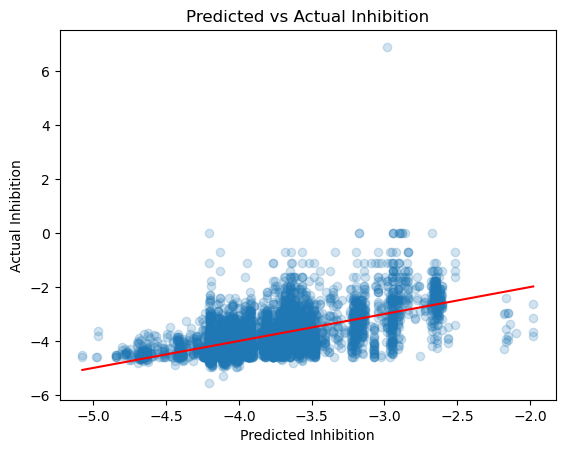

In [45]:
import matplotlib.pyplot as plt

y_predicted = model.predict(test[features])
y_expected = test['log_inhibition']


corr, p_value = pearsonr(y_expected, y_predicted)
print("Pearson Corr: ", corr, " p_value: ", p_value)
corr, p_value = spearmanr(y_expected, y_predicted)
print("Spearman Corr: ", corr, " p_value: ", p_value)
plt.scatter(y_predicted, y_expected, alpha=0.2)
# plt.scatter(y_test, test['gc_content'])
x = np.linspace(np.min(y_predicted), np.max(y_predicted), 100)
plt.plot(x, x, color='red')

plt.xlabel('Predicted Inhibition')
plt.ylabel('Actual Inhibition')
plt.title('Predicted vs Actual Inhibition')
plt.show()

In [46]:
from sklearn.model_selection import permutation_test_score

score, permutation_scores, pvalue = permutation_test_score(model, X, Y, cv=5, n_permutations=100, n_jobs=-1, scoring='r2')
print(score, permutation_scores, pvalue)

0.3286770993926023 [-0.00159604 -0.00288108 -0.00188152 -0.00172328 -0.00270572 -0.00193958
 -0.00254745 -0.00152561 -0.00220165 -0.00159298 -0.0021752  -0.00162285
 -0.00241888 -0.0016576  -0.00216553 -0.00179766 -0.00163548 -0.00171545
 -0.00203824 -0.00156659 -0.00168123 -0.00100025 -0.00197232 -0.0021309
 -0.00180155 -0.00195171 -0.00283631 -0.00234857 -0.00295743 -0.00211362
 -0.0024037  -0.00204982 -0.00182586 -0.00154934 -0.00260707 -0.00150129
 -0.0031911  -0.00252915 -0.00259178 -0.0024211  -0.00188389 -0.00270517
 -0.00251318 -0.00159169 -0.0018668  -0.00203991 -0.00242462 -0.00243607
 -0.00173491 -0.00122465 -0.00150247 -0.0010218  -0.00082527 -0.0016872
 -0.00175564 -0.00185693 -0.00171824 -0.00278649 -0.00263565 -0.00316005
 -0.00338742 -0.00139997 -0.00197594 -0.00182247 -0.00178246 -0.001985
 -0.00244476 -0.00116399 -0.00219282 -0.00258783 -0.00274213 -0.0027336
 -0.00214252 -0.00156732 -0.00287042 -0.00232558 -0.00297977 -0.00290688
 -0.00183206 -0.00281623 -0.00143055 

In [47]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state=42)
rf.fit(filtered[features], filtered['log_inhibition'])

# Get the feature importances
importances = rf.feature_importances_
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

In [48]:
for index, row in importance_df.iterrows():
    print(f"{row['Feature']:<40} {row['Importance']:.3}")

sense_start                              0.528
Treatment_Period(hours)                  0.129
ASO_volume(nM)                           0.0879
log_volume                               0.086
log_density                              0.059
Cell_line_A431                           0.0308
Modification_cEt/5-methylcytosines/deoxy 0.0161
Transfection_free uptake                 0.0157
sense_length                             0.0121
Modification_MOE/cEt/5-methylcytosines/deoxy 0.0102
Cell_line_MM.1R                          0.00413
Cell_line_KMS11                          0.00371
Cell_line_U251                           0.00296
Cell_line_SK-MEL-28                      0.00249
Modification_LNA/deoxy                   0.00221
Modification_MOE/5-methylcytosines/deoxy 0.00195
Modification_cEt/o-methylribose/5-methylcytosines/deoxy 0.00193
Transfection_electroporation             0.00125
Cell_line_SH-SY5Y                        0.000909
Cell_line_KARPAS-229                     0.000767
Cell_line_Hep

In [49]:
# Evaluate the model's choice of features by leaving one out and calculating the score

cv = 5
scorer = spearman_scorer
jobs = -1
feature_importances = []


for feature in feature_base:
    score_without_feature = cross_val_score(model, X.drop(columns=[feature]), Y, cv=cv, scoring=scorer, n_jobs=jobs).mean()
    # print(f"Dropping {feature}: performance drop = {baseline_score - score_without_feature}")
    feature_importances.append((feature, float(baseline_score - score_without_feature)))

print("Done base features")

for i in range(len(one_hot_encoded_features)):
    feature_name = ONE_HOT_FEATURE_NAMES[i]
    feature = one_hot_encoded_features[i]

    score_without_cell_line = cross_val_score(model, X.drop(columns=feature), Y, cv=cv, scoring=scorer, n_jobs=jobs).mean()
    performance_diff = baseline_score - score_without_cell_line
    feature_importances.append((feature_name, float(performance_diff)))

sorted_data = sorted(feature_importances, key=lambda x: x[1], reverse=True)
for datum in sorted_data:
    print(datum)

print("The baseline is: ", baseline_score)
print("The spearman baseline is: ", spearman_score)

The baseline is:  0.3286770993926023
The spearman baseline is:  0.28732121387936294
Done base features
('Cell_line', 0.16248803588779034)
('Transfection', 0.08604828824513602)
('Modification', 0.04454944139230688)
('sense_length', 0.0420491252817663)
('sense_start', 0.03438789096115269)
